In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers

In [2]:
from tensorflow.keras.datasets import boston_housing

In [3]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 0s 1us/step


In [4]:
train_data.shape

(404, 13)

In [5]:
train_targets.shape

(404,)

In [6]:
len(train_data)

404

In [7]:
len(test_data)

102

### Preparing Data

normalizing heterogeneous feature

In [8]:
mean = train_data.mean()
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

### Building network

In [10]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation="relu", input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(1))
    
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    
    return model

### Validating using k-fold validation

since we have such sort number of samples we have to use k-fold validation to validate our approach while training.

In [24]:
k = 4
num_val_samples = len(train_data) // 4
epochs = 100
all_scores = []

for i in range(k):
    
    print("Processing fold #", i)
    
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[: i * num_val_samples],
        train_data[(i + 1) * num_val_samples: ]],
        axis=0)
    
    partial_train_targets = np.concatenate(
        [train_targets[: i * num_val_samples],
        train_targets[(i + 1) * num_val_samples: ]],
        axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs=epochs, batch_size=1, verbose=0)
    
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    
    all_scores.append(val_mae)

Processing fold # 0
Processing fold # 1
Processing fold # 2
Processing fold # 3


In [25]:
all_scores

[4.102581977844238, 5.610401630401611, 3.7604525089263916, 5.333963394165039]

In [26]:
np.mean(all_scores)

4.70184987783432

we are off by ~$4700. Which is a huge amount considering all the targets are between 10K to 50K.

Let’s try training the network a bit longer: 500 epochs. To keep a record of how well the model does at each epoch, you’ll modify the training loop to save the per-epoch validation score log.

In [30]:
k = 4
num_val_samples = len(train_data) // 4
epochs = 500
all_mae_history = []

for i in range(k):
    
    print("Processing fold #", i)
    
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[: i * num_val_samples],
        train_data[(i + 1) * num_val_samples: ]],
        axis=0)
    
    partial_train_targets = np.concatenate(
        [train_targets[: i * num_val_samples],
        train_targets[(i + 1) * num_val_samples: ]],
        axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, 
                        partial_train_targets, 
                        epochs=epochs, 
                        validation_data=(val_data, val_targets),
                        batch_size=1, 
                        verbose=0)
    
    mae_history = history.history['val_mae']
    
    all_mae_history.append(mae_history)

Processing fold # 0
Processing fold # 1
Processing fold # 2
Processing fold # 3


In [32]:
avg_mae_history = [
    np.mean([x[i] for x in all_mae_history]) for i in range(epochs)
]

Plotting validation scores

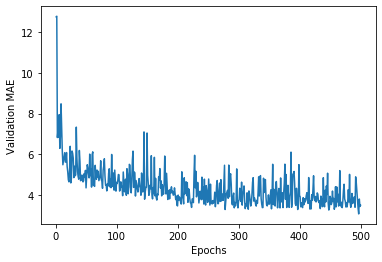

In [33]:
plt.plot(range(1, len(avg_mae_history) + 1), avg_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

It may be a little difficult to see the plot, due to scaling issues and relatively high variance. Let’s do the following:

- Omit the first 10 data points, which are on a different scale than the rest of the curve.
- Replace each point with an exponential moving average of the previous points, to obtain a smooth curve.

In [34]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            prev = smoothed_points[-1]
            smoothed_points.append(prev * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
            
    return smoothed_points

In [36]:
smooth_mae_history = smooth_curve(avg_mae_history[10:])

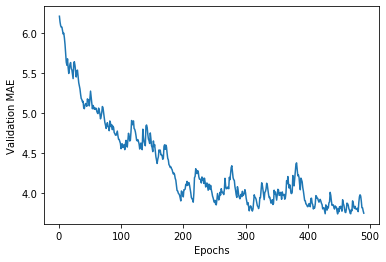

In [37]:
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

As per this chart, the model stops improving after 450 epochs

In [46]:
tf.keras.backend.clear_session()

model = build_model()
model.fit(train_data, train_targets,
          epochs=450, batch_size=16, verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 1ms/step - loss: 32.9912 - mae: 4.0287


In [47]:
test_mae_score

4.02869176864624

We are still off by $4K